In [1]:
import pandas as pd
import numpy as np 
import os 



In [2]:
from sagemaker.session import Session,get_execution_role


In [3]:
sagemaker_session = Session()
bucket = sagemaker_session.default_bucket()
role = get_execution_role()

## Data Exploration and Cleaning

In [4]:
true = pd.read_csv("data/True.csv")
fake = pd.read_csv("data/Fake.csv")

In [5]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


This is the kind of data I will be working with. First things to note down:
* title and text columns must be correctly cleaned before use 
* I will inspect the unique values in true and fake 'subject' column
* date is in a wrong format; I will convert it as it may be useful during feature engineering, fake news tend to grow much in delicate instants for political and international facts. 

Data length and types:

In [7]:
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
title      21417 non-null object
text       21417 non-null object
subject    21417 non-null object
date       21417 non-null object
dtypes: object(4)
memory usage: 669.4+ KB


In [8]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
title      23481 non-null object
text       23481 non-null object
subject    23481 non-null object
date       23481 non-null object
dtypes: object(4)
memory usage: 733.9+ KB


Now, some visualizations to see distribution of 'subject' variable. Which is the most common subject for those who write fake news? Politics?

In [9]:
import matplotlib.pyplot as plt 

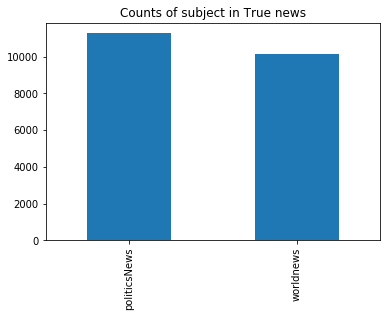

In [10]:
true['subject'].value_counts().plot(kind='bar', title='Counts of subject in True news')

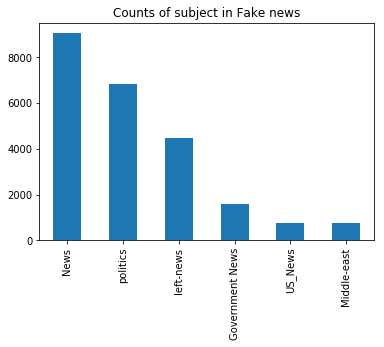

In [11]:
fake['subject'].value_counts().plot(kind='bar', title='Counts of subject in Fake news')

Subjects are mapped differently between True and Fake news as they're numerous in the latter, so I might think of remapping all of the subject of Fake dataset into either politicsNews or worldnews classes to have homogeneity.

First of all, I'd have to give a look at a couple of news mapped as 'left-news' in the fake dataset, as I don't have clear what it refers to.§

In [12]:
fake[fake['subject']=='left-news']['text'].iloc[0]

"Barbra Streisand was an Obama sycophant and one of the corrupt Clinton s most loyal fans. She is also part of the Hollywood liberal  resistance  movement. Much like Rosie O Donnell, Kathy Griffin, and literally hundreds of overpaid celebrities, Barbara Streisand is obsessed with tweeting about how much she hates President Trump. It s Streisand s latest tweet that has conservatives calling her out for her complete and utter  stupidity .Streisand tweeted: Collusion or no collusion, @realDonaldTrump should be impeached for sheer stupidity. Collusion or no collusion, @realDonaldTrump should be impeached for sheer stupidity.  Barbra Streisand (@BarbraStreisand) December 30, 2017Twitter users wasted no time DESTROYING the  has been  entertainer.This tweet suggested her music and acting awards should be recalled due to the  sheer stupidity  of the recipient.I can think of a lot of Oscars, Emmy s, Tony s and Grammy s that should be recalled due to sheer stupidity of the recipient. Particularl

Ok so it refers to fake news made up to discredit left-oriented thinkers, specifically.

Now I can create a single DataFrame consisting of both True and Fake news to apply consistent preparation and cleaning. Before concatenating the two, I'll create the 'class' column, which will be valued 0 for True and 1 for Fake.

In [13]:
true['class'] = 0
fake['class'] = 1

In [14]:
df = pd.concat([true,fake])

In [15]:
#Shuffle the dataframe to randomize things up
df=df.sample(frac=1, random_state=1).reset_index(drop=True)

In [16]:
df.head(10)

,title,text,subject,date,class
0,EPA chief says Paris climate agreement 'bad de...,WASHINGTON (Reuters) - The United States shoul...,politicsNews,"April 2, 2017",0
1,BREAKING NEWS: President Trump Announces Major...,President Trump just tweeted out a new policy ...,politics,"Jul 26, 2017",1
2,Trump says New Hampshire win not necessary to ...,WASHINGTON (Reuters) - U.S. Republican preside...,politicsNews,"February 7, 2016",0
3,Kremlin: U.S. sanctions aimed at turning busin...,MOSCOW (Reuters) - The Kremlin said on Thursda...,worldnews,"November 30, 2017",0
4,MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...,Kellyanne Conway s response to Williams criti...,left-news,"Dec 27, 2016",1
5,Poland's PM designate says will continue fight...,WARSAW (Reuters) - Poland will continue fighti...,worldnews,"December 8, 2017",0
6,One more Republican defection would doom Senat...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"July 14, 2017",0
7,IT BEGINS: ANTHONY SCARAMUCCI FIRES Suspected ...,Scaramucci promised the heads of White House l...,politics,"Jul 25, 2017",1
8,Refugee Living In England Arrested For Threate...,"Here is just one more, in a long line of stori...",left-news,"Jan 27, 2016",1
9,"Cory Booker EVISCERATES RNC’s Hateful Tone, ‘...",Senator Cory Booker was none too happy with wh...,News,"July 23, 2016",1


To parse this date column, I'll make use of the Python's dateutil package. 

In [17]:
!pip install python-dateutil

You should consider upgrading via the 'pip install --upgrade pip' command.


In [18]:
from dateutil import parser

In [19]:
df['date'] = df['date'].apply(parser.parse)

ValueError: ('Unknown string format:', 'https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/')

I found this ValueError because apparently there is some sort of data quality issue in the 'date' column. 

I'll define a function with a try-except block in order to parse all the parseable and set nan to the rest to see how much invalid entries there are.

In [ ]:
def parse_date(x):
    
    try:
        
        return parser.parse(x)
    
    except:
        
        return np.nan

In [ ]:
df['date'] = df['date'].apply(parse_date)

In [ ]:
df['date'].head()

It has worked, but I want to check how many rows are nan.

In [20]:
df[df.isna().any(axis=1)]

,title,text,subject,date,class


Perfect, as they are only ~ 10 rows I can easily drop them, the curious thing is that they all belong to the fake class.

In [21]:
df.dropna(inplace=True)

In [22]:
len(df)

44898

In [23]:
df['class'].value_counts()/len(df)

1    0.522985
0    0.477015
Name: class, dtype: float64

Perfect, so the target is well-balanced. I will now perform the mapping of the 'subject' column as I said before.

In [24]:
df['subject'].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

* politicsNew,politics,left-news,government News -> politics

* worldnews, news, US_News, Middle-east -> general

In [25]:
#Create a single view of multiple mappings
from collections import ChainMap
to_politics = ["politicsNews","left-news","Government News","politics"]
to_general = ["worldnews", "News","US_News", "Middle-east"]
full_map = ChainMap(dict.fromkeys(to_politics,'politics'),dict.fromkeys(to_general,'general'))

In [26]:
df['subject'] = df['subject'].map(full_map.get)

In [27]:
df['subject'].value_counts()

politics    24142
general     20756
Name: subject, dtype: int64

In [28]:
df.head()

,title,text,subject,date,class
0,EPA chief says Paris climate agreement 'bad de...,WASHINGTON (Reuters) - The United States shoul...,politics,"April 2, 2017",0
1,BREAKING NEWS: President Trump Announces Major...,President Trump just tweeted out a new policy ...,politics,"Jul 26, 2017",1
2,Trump says New Hampshire win not necessary to ...,WASHINGTON (Reuters) - U.S. Republican preside...,politics,"February 7, 2016",0
3,Kremlin: U.S. sanctions aimed at turning busin...,MOSCOW (Reuters) - The Kremlin said on Thursda...,general,"November 30, 2017",0
4,MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...,Kellyanne Conway s response to Williams criti...,politics,"Dec 27, 2016",1


In [29]:
def process_text(text, length=False, stem=False):
    from nltk.stem import PorterStemmer
    from nltk.corpus import stopwords
    try:
    
        stop_words = set(stopwords.words('english'))
    
    except:
        
        import nltk
        nltk.download('stopwords')
        
        stop_words = set(stopwords.words('english'))
    if stem:    
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word.lower()) for word in text.split() if (word.isalpha()) and (word not in stop_words)]
    else:
        tokens = [word.lower() for word in text.split() if (word.isalpha()) and (word not in stop_words)]

    cleaned_text = ' '.join(tokens)

    if length:
        length_of_text = len(tokens)
        return cleaned_text,length_of_text
    else:
        return cleaned_text

In [30]:
!pip install tqdm
from tqdm import tqdm

     |████████████████████████████████| 61kB 1.4MB/s  eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [32]:
for index, row in tqdm( df.iterrows(), total=df.shape[0]):
    
    df.at[index,'cleanedText'],df.at[index,'textLength'] = process_text(row['text'], length=True,stem=True)
    df.at[index,'cleanedTitle']= process_text(row['title'],stem=False)

100%|██████████| 44898/44898 [03:47<00:00, 197.02it/s]


In [39]:
df.head()

,title,text,subject,date,class,cleanedText,textLength,cleanedTitle
0,EPA chief says Paris climate agreement 'bad de...,WASHINGTON (Reuters) - The United States shoul...,politics,2017-04-02,0,washington the united states continue internat...,206.0,epa chief says paris climate agreement
1,BREAKING NEWS: President Trump Announces Major...,President Trump just tweeted out a new policy ...,politics,2017-07-26,1,president trump tweeted new policy us military...,57.0,breaking president trump announces major polic...
2,Trump says New Hampshire win not necessary to ...,WASHINGTON (Reuters) - U.S. Republican preside...,politics,2016-02-07,0,washington republican presidential candidate d...,158.0,trump says new hampshire win necessary secure ...
3,Kremlin: U.S. sanctions aimed at turning busin...,MOSCOW (Reuters) - The Kremlin said on Thursda...,general,2017-11-30,0,moscow the kremlin said thursday confident uni...,44.0,sanctions aimed turning business elite putin
4,MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...,Kellyanne Conway s response to Williams criti...,politics,2016-12-27,1,kellyanne conway response williams criticism c...,8.0,must kellyanne conway punches back after juan ...


In [40]:
cleaned_df = df[['cleanedText','textLength','cleanedTitle','date','subject','class']].copy()

In [41]:
cleaned_df.head()

,cleanedText,textLength,cleanedTitle,date,subject,class
0,washington the united states continue internat...,206.0,epa chief says paris climate agreement,2017-04-02,politics,0
1,president trump tweeted new policy us military...,57.0,breaking president trump announces major polic...,2017-07-26,politics,1
2,washington republican presidential candidate d...,158.0,trump says new hampshire win necessary secure ...,2016-02-07,politics,0
3,moscow the kremlin said thursday confident uni...,44.0,sanctions aimed turning business elite putin,2017-11-30,general,0
4,kellyanne conway response williams criticism c...,8.0,must kellyanne conway punches back after juan ...,2016-12-27,politics,1


Now, I will extract some features from the date column: 
* weekofyear,dayofweek,dayofyear, quarter
* is_month_start,is_month_end,is_year_start, is_year_end

In [42]:
cleaned_df['weekOfYear'] = cleaned_df['date'].dt.weekofyear
cleaned_df['dayOfWeek'] = cleaned_df['date'].dt.dayofweek
cleaned_df['dayOfYear'] = cleaned_df['date'].dt.dayofyear
cleaned_df['quarter'] =  cleaned_df['date'].dt.quarter
cleaned_df['isMonthStart'] = cleaned_df['date'].dt.is_month_start
cleaned_df['isMonthEnd'] = cleaned_df['date'].dt.is_month_end
cleaned_df['isYearStart'] = cleaned_df['date'].dt.is_year_start
cleaned_df['isYearEnd'] = cleaned_df['date'].dt.is_year_end

I am ready to save the data on S3.

In [44]:
prefix='udacityCapstone/data'
cleaned_df.to_csv('data/cleaned_data_nostem.csv')

sagemaker_session.upload_data(bucket=bucket, key_prefix=prefix, path='data/cleaned_data_nostem.csv')

's3://sagemaker-eu-central-1-126514844793/udacityCapstone/data/cleaned_data_nostem.csv'